# Linear Regression Lab

## Part 1: Read and parse the initial dataset

### (1a) Load and check the data

In [1]:
import os.path
file_name = os.path.join('millionsong.txt')
raw_data_df = sqlContext.read.load(file_name, 'text')
num_points = raw_data_df.count()
print(num_points)
sample_points = raw_data_df.take(5)
print(sample_points)

6724
[Row(value=u'2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817'), Row(value=u'2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624'), Row(value=u'2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818'), Row(value=u'2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173'), Row(value=u'2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.46337

### (1b) Using LabeledPoint

In [2]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [3]:
from pyspark.sql import functions as sql_functions

def parse_points(df):
    """Converts a DataFrame of comma separated unicode strings into a DataFrame of `LabeledPoints`.

    Args:
        df: DataFrame where each row is a comma separated unicode string. The first element in the string
            is the label and the remaining elements are the features.

    Returns:
        DataFrame: Each row is converted into a `LabeledPoint`, which consists of a label and
            features. To convert an RDD to a DataFrame, simply call toDF().
    """
    return df.rdd.map(lambda x: LabeledPoint(x[0].split(",")[0], x[0].split(",")[1:])).toDF()

parsed_points_df = parse_points(raw_data_df)
first_point_features = parsed_points_df.take(1)[0].features
first_point_label = parsed_points_df.take(1)[0].label
print(first_point_features, first_point_label)

d = len(first_point_features)
print(d)

(DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), 2001.0)
12


### Visualization 1: Features

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


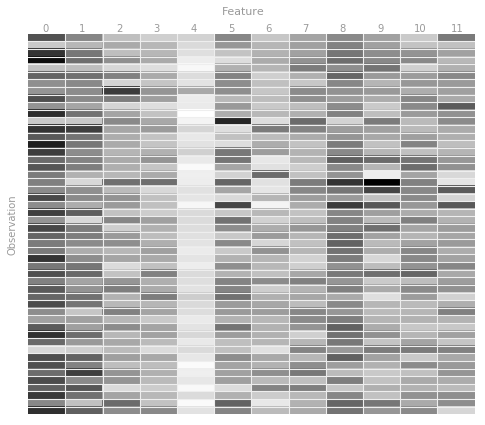

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# takeSample(withReplacement, num, [seed]) randomly selects num elements from the dataset with/without replacement, and has an
# optional seed parameter that one can set for reproducible results

data_values = (parsed_points_df
               .rdd
               .map(lambda lp: lp.features.toArray())
               .takeSample(False, 50, 47))

# You can uncomment the line below to see randomly selected features.  These will be randomly
# selected each time you run the cell because there is no set seed.  Note that you should run
# this cell with the line commented out when answering the lab quiz questions.
# data_values = (parsedPointsDF
#                .rdd
#                .map(lambda lp: lp.features.toArray())
#                .takeSample(False, 50))

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                 gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = prepare_plot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                       gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(data_values,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
fig.show()

### (1c) Find the range

In [5]:
content_stats = (parsed_points_df
                 .selectExpr("min(label)", "max(label)"))

min_year = content_stats.first()[0]
max_year = content_stats.first()[1]

print(min_year, max_year)

(1922.0, 2011.0)


### (1d) Shift labels

In [6]:
from pyspark.sql.functions import col,lit
parsed_data_df = parsed_points_df.select(col("features"), (col("label")-lit(min_year)).alias("label"))

# View the first point
print('\n{0}'.format(parsed_data_df.first()))


Row(features=DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), label=79.0)


### Visualization 2: Shifting labels

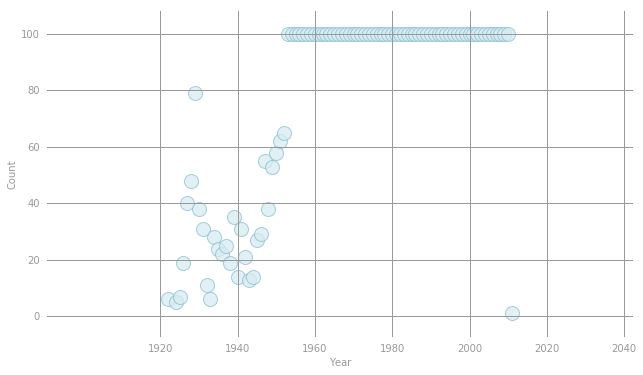

In [7]:
# get data for plot
old_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*old_data)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
fig.show()

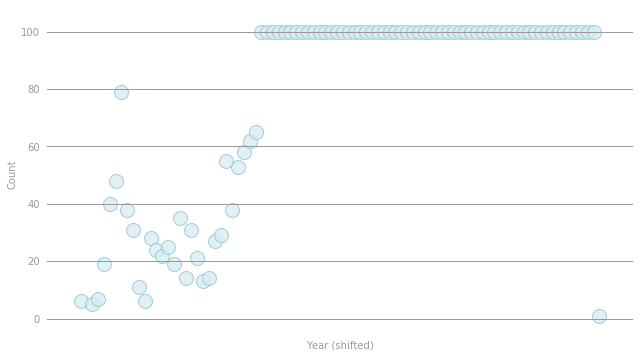

In [8]:
# get data for plot
new_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*new_data)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 120, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)'), ax.set_ylabel('Count')
fig.show()

### (1e) Training, validation, and test sets

In [9]:
weights = [.8, .1, .1]
seed = 42
parsed_train_data_df, parsed_val_data_df, parsed_test_data_df = parsed_data_df.randomSplit(weights, seed)
parsed_train_data_df.cache()
parsed_val_data_df.cache()
parsed_test_data_df.cache()
n_train = parsed_train_data_df.count()
n_val = parsed_val_data_df.count()
n_test = parsed_test_data_df.count()

print(n_train, n_val, n_test, n_train + n_val + n_test)
print(parsed_data_df.count())

(5405, 644, 675, 6724)
6724


In [10]:
parsed_train_data_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.6962697800...| 59.0|
|[0.0305925311676,...| 35.0|
|[0.0360221885556,...| 62.0|
|[0.0617881668395,...|  6.0|
|[0.0699897994647,...| 35.0|
|[0.0806538839906,...|  6.0|
|[0.0818546971883,...|  6.0|
|[0.0877822407675,...| 35.0|
|[0.10320837371,0....|  6.0|
|[0.107048719513,0...| 62.0|
|[0.110369105352,0...|  6.0|
|[0.112416325075,0...|  7.0|
|[0.117417506022,0...| 35.0|
|[0.121345656384,0...| 62.0|
|[0.122991133456,0...|  7.0|
|[0.12476071418,0....| 84.0|
|[0.126361798443,0...| 40.0|
|[0.129940202152,0...| 68.0|
|[0.134600956481,0...| 64.0|
|[0.138250977316,0...| 35.0|
+--------------------+-----+
only showing top 20 rows



## Part 2: Create and evaluate a baseline model

### (2a) Average label

In [11]:
average_train_year = (parsed_train_data_df
                        .selectExpr("avg(label)")).first()[0]
print(average_train_year)

53.6814061055


### (2b) Root mean squared error

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

preds_and_labels = [(1., 3.), (2., 1.), (2., 2.)]
preds_and_labels_df = sqlContext.createDataFrame(preds_and_labels, ["prediction", "label"])

evaluator = RegressionEvaluator()
def calc_RMSE(dataset):
    """Calculates the root mean squared error for an dataset of (prediction, label) tuples.

    Args:
        dataset (DataFrame of (float, float)): A `DataFrame` consisting of (prediction, label) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return evaluator.evaluate(dataset)

example_rmse = calc_RMSE(preds_and_labels_df)
print(example_rmse)

1.29099444874


### (2c) Training, validation and test RMSE

In [13]:
preds_and_labels_train = parsed_train_data_df.rdd.map(lambda x: (average_train_year, x[1]))
preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
rmse_train_base = calc_RMSE(preds_and_labels_train_df)

preds_and_labels_val = parsed_val_data_df.rdd.map(lambda x: (average_train_year, x[1]))
preds_and_labels_val_df = sqlContext.createDataFrame(preds_and_labels_val, ["prediction", "label"])
rmse_val_base = calc_RMSE(preds_and_labels_val_df)

preds_and_labels_test = parsed_test_data_df.rdd.map(lambda x: (average_train_year, x[1]))
preds_and_labels_test_df = sqlContext.createDataFrame(preds_and_labels_test, ["prediction", "label"])
rmse_test_base = calc_RMSE(preds_and_labels_test_df)

print('Baseline Train RMSE = {0:.3f}'.format(rmse_train_base))
print('Baseline Validation RMSE = {0:.3f}'.format(rmse_val_base))
print('Baseline Test RMSE = {0:.3f}'.format(rmse_test_base))

Baseline Train RMSE = 21.477
Baseline Validation RMSE = 21.227
Baseline Test RMSE = 21.127


### Visualization 3: Predicted vs. actual

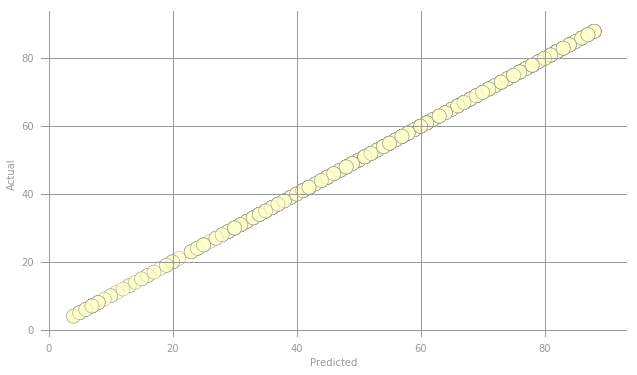

In [14]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

def squared_error(label, prediction):
    """Calculates the squared error for a single prediction."""
    return float((label - prediction)**2)

actual = np.asarray(parsed_val_data_df
                    .select('label')
                    .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda (l, p): squared_error(l, p))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
fig.show()

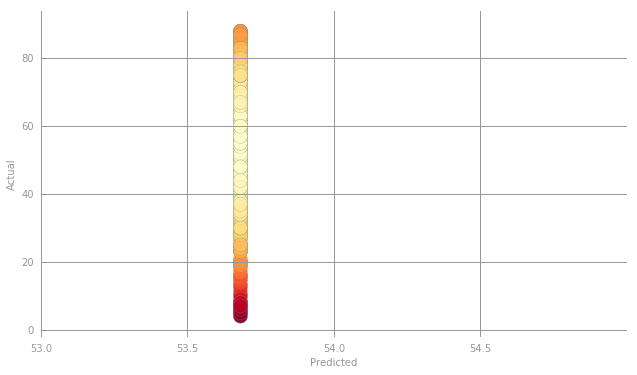

In [15]:
def squared_error(label, prediction):
    """Calculates the squared error for a single prediction."""
    return float((label - prediction)**2)

predictions = np.asarray(parsed_val_data_df
                         .rdd
                         .map(lambda lp: average_train_year)
                         .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, average_train_year))
                   .map(lambda (l, p): squared_error(l, p))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
fig.show()

## Part 3: Train (via gradient descent) and evaluate a linear regression model

### (3a) Gradient summand

In [16]:
from pyspark.mllib.linalg import DenseVector
def gradient_summand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    return (weights.dot(lp.features)-lp.label) * lp.features

example_w = DenseVector([1, 1, 1])
example_lp = LabeledPoint(2.0, [3, 1, 4])
# gradient_summand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
summand_one = gradient_summand(example_w, example_lp)
print(summand_one)

example_w = DenseVector([.24, 1.2, -1.4])
example_lp = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summand_two = gradient_summand(example_w, example_lp)
print(summand_two)

[18.0,6.0,24.0]
[1.7304,-5.1912,-2.5956]


### (3b) Use weights to make predictions

In [17]:
def get_labeled_prediction(weights, observation):
    """Calculates predictions and returns a (prediction, label) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (prediction, label) tuple. Convert the return type of the label and prediction to a float.
    """
    return (float(weights.dot(observation.features)), float(observation.label))

weights = np.array([1.0, 1.5])
prediction_example = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                     LabeledPoint(1.5, np.array([.5, .5]))])
preds_and_labels_example = prediction_example.map(lambda lp: get_labeled_prediction(weights, lp))
print(preds_and_labels_example.collect())

[(1.75, 2.0), (1.25, 1.5)]


### (3c) Gradient descent

In [18]:
def linreg_gradient_descent(train_data, num_iters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        train_data (RDD of LabeledPoint): The labeled data for use in training the model.
        num_iters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = train_data.count()
    # The number of features in the training data
    d = len(train_data.first().features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    error_train = np.zeros(num_iters)
    for i in range(num_iters):
        # Use get_labeled_prediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        preds_and_labels_train = train_data.map(lambda lp: get_labeled_prediction(w, lp))        
        preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
        error_train[i] = calc_RMSE(preds_and_labels_train_df)

        # Calculate the `gradient`.  Make use of the `gradient_summand` function you wrote in (3a).
        # Note that `gradient` should be a `DenseVector` of length `d`.
        gradient = train_data.map(lambda x: gradient_summand(w, x)).reduce(lambda x, y: x + y)

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient
    return w, error_train

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linreg_gradient_descent is working properly
example_n = 10
example_d = 3
example_data = (sc
                 .parallelize(parsed_train_data_df.take(example_n))
                 .map(lambda lp: LabeledPoint(lp.label, lp.features[0:example_d])))
print(example_data.take(2))
example_num_iters = 5
#linreg_gradient_descent(example_data, example_num_iters)
example_weights, example_error_train = linreg_gradient_descent(example_data, example_num_iters)
print(example_weights)

[LabeledPoint(59.0, [0.0,0.696269780071,0.395207288435]), LabeledPoint(35.0, [0.0305925311676,0.402530811194,0.296196625953])]
[  3.6706757   28.77277769  17.91957382]


### (3d) Train the model

In [19]:
num_iters = 50
weights_LR0, error_train_LR0 = linreg_gradient_descent(parsed_train_data_df.rdd, num_iters)

preds_and_labels = (parsed_val_data_df
                      .rdd.map(lambda lp: get_labeled_prediction(weights_LR0, lp)))
preds_and_labels_df = sqlContext.createDataFrame(preds_and_labels, ["prediction", "label"])
rmse_val_LR0 = calc_RMSE(preds_and_labels_df)

print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmse_val_base,
                                                                       rmse_val_LR0))

Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776


### Visualization 4: Training error

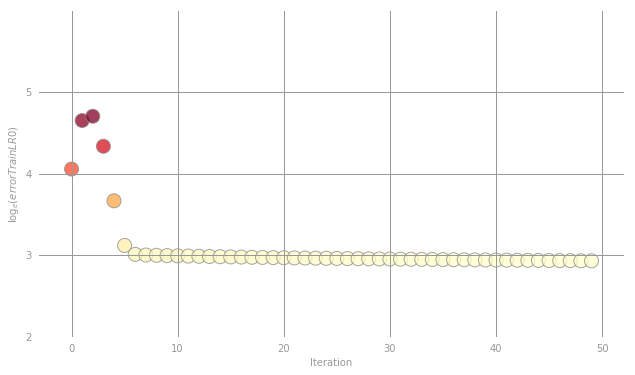

In [20]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(error_train_LR0))))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, num_iters), np.log(error_train_LR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
fig.show()

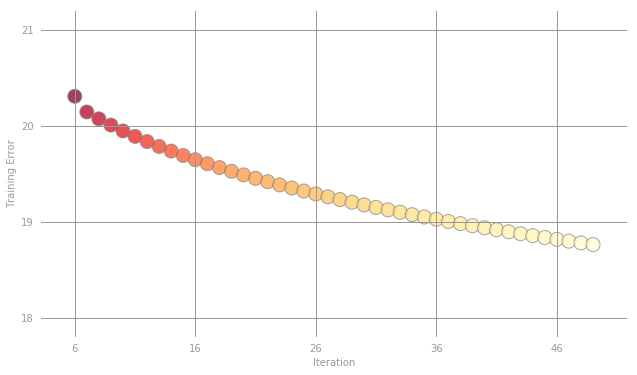

In [21]:
norm = Normalize()
clrs = cmap(np.asarray(norm(error_train_LR0[6:])))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, num_iters-6), error_train_LR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
fig.show()

## Part 4: Train using SparkML and perform grid search

### (4a) `LinearRegression`

In [22]:
from pyspark.ml.regression import LinearRegression
# Values to use when training the linear regression model

num_iters = 500  # iterations
reg = 1e-1  # regParam
alpha = .2  # elasticNetParam
use_intercept = True  # intercept

In [23]:
from pyspark.ml.linalg import Vectors as MLVectors
parsed_train_data_ml_vectors_df = (parsed_train_data_df
                                   .rdd.map(lambda x : (MLVectors.dense(x[0]), x[1]))
                                   .toDF(['features', 'label']))

lin_reg = LinearRegression(maxIter=num_iters, regParam=reg, elasticNetParam=alpha)
first_model = lin_reg.fit(parsed_train_data_ml_vectors_df)

# coeffsLR1 stores the model coefficients; interceptLR1 stores the model intercept
coeffs_LR1 = first_model.coefficients
intercept_LR1 = first_model.intercept
print(coeffs_LR1, intercept_LR1)

(DenseVector([23.4358, 25.3296, -67.3412, 57.7582, -11.0637, -53.4227, 33.8671, -18.6251, 2.6684, -2.9052, -13.9241, -11.1629]), 64.05700913314044)


### (4b) Transform

In [25]:
sample_prediction = first_model.transform(parsed_train_data_ml_vectors_df)
sample_prediction.show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.0,0.6962697800...| 59.0|38.044285032181534|
|[0.0305925311676,...| 35.0| 44.36117786829425|
|[0.0360221885556,...| 62.0| 33.88821007504307|
|[0.0617881668395,...|  6.0| 42.47243862328028|
|[0.0699897994647,...| 35.0|  42.9116375594912|
|[0.0806538839906,...|  6.0| 36.40521198683931|
|[0.0818546971883,...|  6.0| 39.59336330278951|
|[0.0877822407675,...| 35.0|49.910458657180556|
|[0.10320837371,0....|  6.0|31.553150369663406|
|[0.107048719513,0...| 62.0| 48.67967174541538|
|[0.110369105352,0...|  6.0|  36.1523321111302|
|[0.112416325075,0...|  7.0| 32.04392277347763|
|[0.117417506022,0...| 35.0| 41.01274567538877|
|[0.121345656384,0...| 62.0| 58.05442927841362|
|[0.122991133456,0...|  7.0|15.181055603914025|
|[0.12476071418,0....| 84.0|  63.6544099988935|
|[0.126361798443,0...| 40.0| 51.39091977711937|
|[0.129940202152,0...| 68.0|57.652108600

### (4c) Evaluate RMSE

In [26]:
parsed_val_data_ml_vectors_df = (parsed_val_data_df
                                   .rdd.map(lambda x : (MLVectors.dense(x[0]), x[1]))
                                   .toDF(['features', 'label']))

val_pred_df = first_model.transform(parsed_val_data_ml_vectors_df)
rmse_val_LR1 = calc_RMSE(val_pred_df)

print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}' +
       '\n\tLR1 = {2:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1)

Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776
	LR1 = 15.961


### (4d) Grid search

In [27]:
best_RMSE = rmse_val_LR1
best_reg_param = reg
best_model = first_model

num_iters = 500  # iterations
alpha = .2  # elasticNetParam
use_intercept = True  # intercept

for reg in [1e-10, 1e-5, 1.0]:
    lin_reg = LinearRegression(maxIter=num_iters, regParam=reg, elasticNetParam=alpha, fitIntercept=use_intercept)
    model = lin_reg.fit(parsed_train_data_ml_vectors_df)
    val_pred_df = model.transform(parsed_val_data_ml_vectors_df)

    rmse_val_grid = calc_RMSE(val_pred_df)
    print(rmse_val_grid)

    if rmse_val_grid < best_RMSE:
        best_RMSE = rmse_val_grid
        best_reg_param = reg
        best_model = model

rmse_val_LR_grid = best_RMSE

print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' +
       '\tLRGrid = {3:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1, rmse_val_LR_grid)

15.9744586685
15.974456546
15.9080557886
Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776
	LR1 = 15.961
	LRGrid = 15.908


### Visualization 5: Best model's predictions

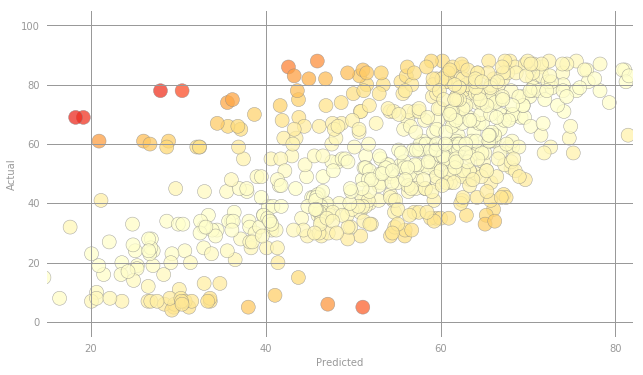

In [28]:
parsed_val_df = best_model.transform(parsed_val_data_ml_vectors_df)
predictions = np.asarray(parsed_val_df
                         .select('prediction')
                         .collect())
actual = np.asarray(parsed_val_df
                      .select('label')
                      .collect())
error = np.asarray(parsed_val_df
                     .rdd
                     .map(lambda lp: squared_error(lp.label, lp.prediction))
                     .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
fig.show()

### Visualization 6: Hyperparameter heat map

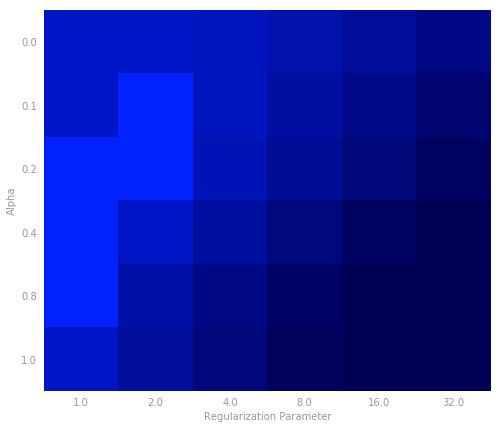

In [29]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
num_iters = 500
reg_params = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
alpha_params = [0.0, .1, .2, .4, .8, 1.0]
rmse_val = np.array([[ 15.317156766552452, 15.327211561989827, 15.357152971253697, 15.455092206273847, 15.73774335576239,
                       16.36423857334287, 15.315019185101972, 15.305949211619886, 15.355590337955194, 15.573049001631558,
                       16.231992712117222, 17.700179790697746, 15.305266383061921, 15.301104931027034, 15.400125020566225,
                       15.824676190630191, 17.045905140628836, 19.365558346037535, 15.292810983243772, 15.333756681057828,
                       15.620051033979871, 16.631757941340428, 18.948786862836954, 20.91796910560631, 15.308301384150049,
                       15.522394576046239, 16.414106221093316, 18.655978799189178, 20.91796910560631, 20.91796910560631,
                       15.33442896030322, 15.680134490745722, 16.86502909075323, 19.72915603626022, 20.91796910560631,
                       20.91796910560631 ]])

num_rows, num_cols = len(alpha_params), len(reg_params)
rmse_val = np.array(rmse_val)
rmse_val.shape = (num_rows, num_cols)

fig, ax = prepare_plot(np.arange(0, num_cols, 1), np.arange(0, num_rows, 1), figsize=(8, 7), hideLabels=True,
                       gridWidth=0.)
ax.set_xticklabels(reg_params), ax.set_yticklabels(alpha_params)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Alpha')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmse_val,interpolation='nearest', aspect='auto',
                    cmap = colors)
fig.show()

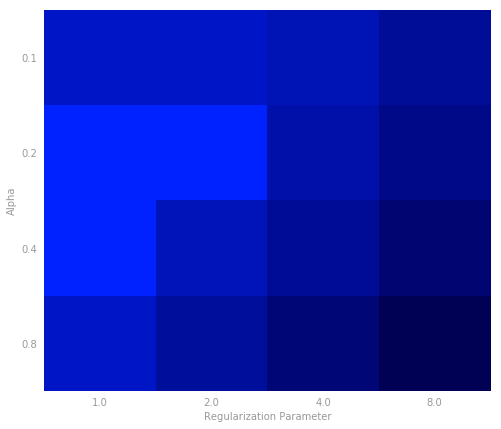

In [30]:
# Zoom into the top left
alpha_params_zoom, reg_params_zoom = alpha_params[1:5], reg_params[:4]
rmse_val_zoom = rmse_val[1:5, :4]

num_rows, num_cols = len(alpha_params_zoom), len(reg_params_zoom)

fig, ax = prepare_plot(np.arange(0, num_cols, 1), np.arange(0, num_rows, 1), figsize=(8, 7), hideLabels=True,
                       gridWidth=0.)
ax.set_xticklabels(reg_params_zoom), ax.set_yticklabels(alpha_params_zoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Alpha')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmse_val_zoom, interpolation='nearest', aspect='auto',
                    cmap = colors)
fig.show()

### Part 5: Add interactions between features

### (5a) Add 2-way interactions

In [31]:
import itertools

def two_way_interactions(lp):
    """ Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    vec = []
    for x in itertools.product(lp.features, lp.features):
        vec.append( x[0] * x[1])
    return LabeledPoint(lp.label, np.hstack((lp.features, vec)))

print(two_way_interactions(LabeledPoint(0.0, [2, 3])))

# Transform the existing train, validation, and test sets to include two-way interactions.
# Remember to convert them back to DataFrames at the end.
train_data_interact_df = parsed_train_data_df.rdd.map(lambda x: two_way_interactions(x)).toDF()
val_data_interact_df = parsed_val_data_df.rdd.map(lambda x: two_way_interactions(x)).toDF()
test_data_interact_df = parsed_test_data_df.rdd.map(lambda x: two_way_interactions(x)).toDF()

(0.0,[2.0,3.0,4.0,6.0,6.0,9.0])


### (5b) Build interaction model

In [32]:
num_iters = 500
reg = 1e-10
alpha = .2
use_intercept = True

train_data_interact_ml_vectors_df = (train_data_interact_df
                                     .rdd.map(lambda x : (MLVectors.dense(x[0]), x[1]))
                                     .toDF(['features', 'label']))
val_data_interact_ml_vectors_df = (val_data_interact_df
                                   .rdd.map(lambda x : (MLVectors.dense(x[0]), x[1]))
                                   .toDF(['features', 'label']))

lin_reg = LinearRegression(maxIter=num_iters, regParam=reg, elasticNetParam=alpha, fitIntercept=use_intercept)
model_interact = lin_reg.fit(train_data_interact_ml_vectors_df)
preds_and_labels_interact_df = model_interact.transform(val_data_interact_ml_vectors_df)
rmse_val_interact = calc_RMSE(preds_and_labels_interact_df)

print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' +
       '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1,
                                                 rmse_val_LR_grid, rmse_val_interact)

Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776
	LR1 = 15.961
	LRGrid = 15.908
	LRInteract = 15.027


### (5c) Evaluate interaction model on test data

In [33]:
test_data_interact_ml_vectors_df = (test_data_interact_df
                                    .rdd.map(lambda x : (MLVectors.dense(x[0]), x[1]))
                                    .toDF(['features', 'label']))
preds_and_labels_test_df = model_interact.transform(test_data_interact_ml_vectors_df)
rmse_test_interact = calc_RMSE(preds_and_labels_test_df)

print('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmse_test_base, rmse_test_interact))

Test RMSE:
	Baseline = 21.127
	LRInteract = 15.367


### (5d) Use a pipeline to create the interaction model

In [34]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import PolynomialExpansion

num_iters = 500
reg = 1e-10
alpha = .2
use_intercept = True

polynomial_expansion = PolynomialExpansion(degree=2, inputCol="features", outputCol="polyFeatures")
linear_regression = LinearRegression(maxIter=num_iters, regParam=reg, elasticNetParam=alpha,
                                     fitIntercept=use_intercept, featuresCol='polyFeatures')
parsed_test_data_ml_vectors_df = (parsed_test_data_df
                                    .rdd.map(lambda x : (MLVectors.dense(x[0]), x[1]))
                                    .toDF(['features', 'label']))

pipeline = Pipeline(stages=[polynomial_expansion, linear_regression])
pipeline_model = pipeline.fit(parsed_train_data_ml_vectors_df)

predictions_df = pipeline_model.transform(parsed_test_data_ml_vectors_df)

evaluator = RegressionEvaluator()
rmse_test_pipeline = evaluator.evaluate(predictions_df, {evaluator.metricName: "rmse"})
print('RMSE for test data set using pipelines: {0:.3f}'.format(rmse_test_pipeline))

RMSE for test data set using pipelines: 15.367
